In [1]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
data_path = 'data/solar_data.csv'

solar = pd.read_csv(data_path)

In [9]:
solar.head()

,Date,Time,solar_output,temperature,humidity,wind_speed,visibility
0,01-10-16,6:00,0.0,27.0,74.0,0.00,4.0
1,01-10-16,6:05,0.0,27.0,74.0,0.56,4.0
2,01-10-16,6:10,0.0,27.0,74.0,1.00,4.0
3,01-10-16,6:15,0.0,27.0,74.0,1.33,4.0
4,01-10-16,6:20,0.0,27.0,74.0,1.57,4.0


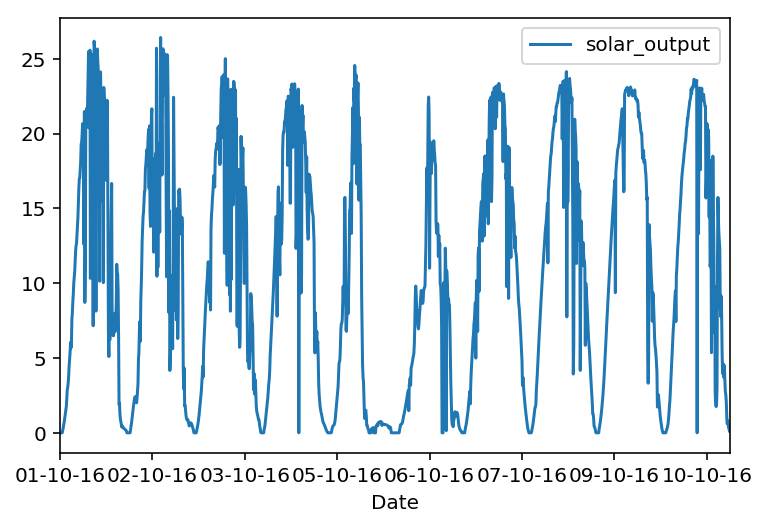

In [11]:
solar[:145*10].plot(x='Date', y='solar_output')

## Scaling the Target variables

In [12]:
quant_features = ['solar_output', 'temperature', 'humidity', 'wind_speed', 'visibility']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = solar[each].mean(), solar[each].std()
    scaled_features[each] = [mean, std]
    solar.loc[:, each] = (solar[each] - mean)/std

In [16]:
data=solar.drop(['Date','Time'],axis=1)
data.head()

,solar_output,temperature,humidity,wind_speed,visibility
0,-1.381993,0.456044,1.631819,-1.515159,0.194694
1,-1.381993,0.456044,1.631819,-1.402889,0.194694
2,-1.381993,0.456044,1.631819,-1.314677,0.194694
3,-1.381993,0.456044,1.631819,-1.248519,0.194694
4,-1.381993,0.456044,1.631819,-1.200403,0.194694


## Splitting DataSet

In [17]:
# Save the last 21 days 
test_data = data[-21*145:]
data = data[:-21*145]

# Separate the data into features and targets
target_fields = ['solar_output']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [19]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*145], targets[:-60*145]
val_features, val_targets = features[-60*145:], targets[-60*145:]

## Building Neural Network

In [20]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        hidden_outputs = self.activation_function(hidden_inputs) 
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) 
        final_outputs = final_inputs 
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error
        output_errors = targets - final_outputs 
        
        # TODO: Backpropagated error
        hidden_errors =  np.dot(self.weights_hidden_to_output.T, output_errors) 
        hidden_grad = hidden_outputs * (1 - hidden_outputs) 
        
        # TODO: Update the weights
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T) 
        self.weights_input_to_hidden += self.lr * hidden_grad * np.dot(hidden_errors, inputs.T) 
    
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [21]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [43]:
import sys

### Set the hyperparameters here ###
epochs = 20000
learning_rate = 0.0001
hidden_nodes = 8
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['solar_output']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['solar_output'].values)
    val_loss = MSE(network.run(val_features), val_targets['solar_output'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 89.3% ... Training loss: 0.582 ... Validation loss: 1.087

KeyboardInterrupt: 

(0.53268053044742825, 0.5)

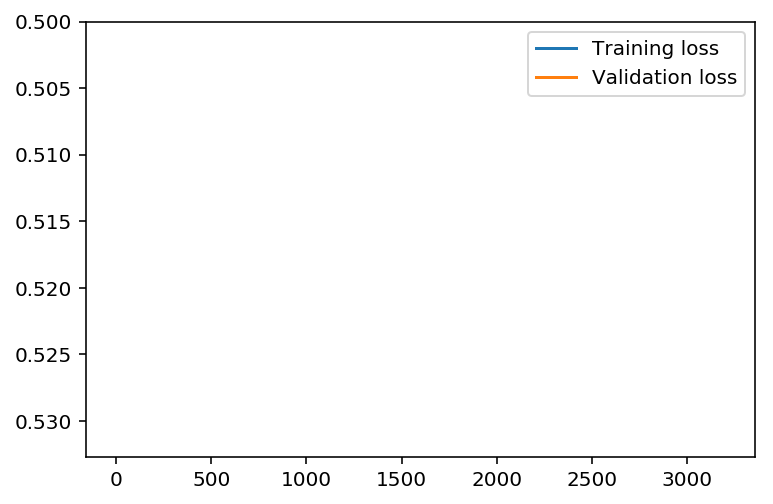

In [24]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

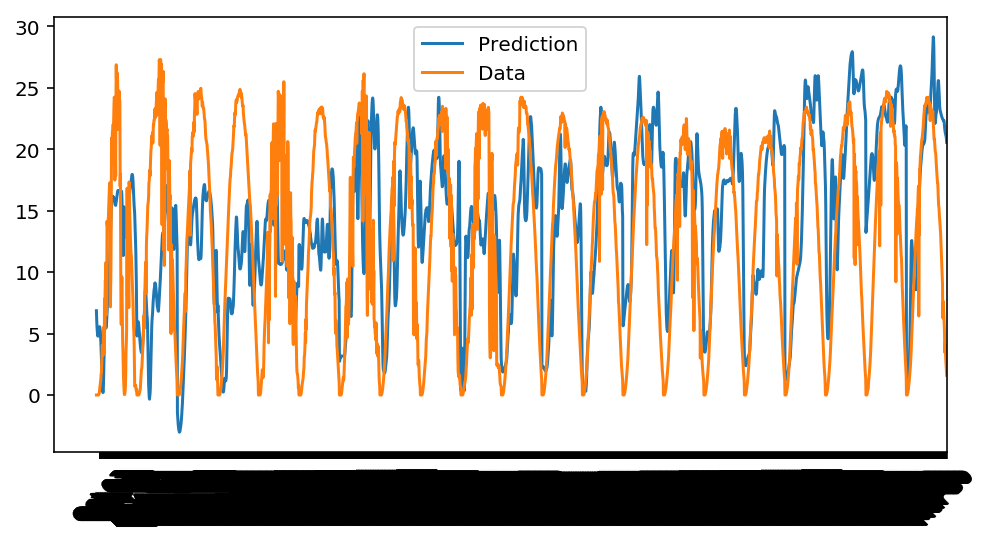

In [26]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['solar_output']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['solar_output']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['Date'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)